In [1]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import librosa
import librosa.display
from numba import njit

In [2]:
filename = 'natural/flute/443Hz'
data, samplerate = sf.read(filename + ".wav", dtype='float64')
sample_len = len(data)/samplerate

Audio(filename + ".wav", rate=samplerate)

In [3]:
def low_pass_filter(signal, cutoff, sr = 44100, q = 1):
    signal = np.array(signal)
    if not hasattr(cutoff, "__iter__"):
        cutoff = np.broadcast_to(np.array([cutoff]), signal.shape)
    else:
        cutoff = np.array(cutoff)
    return _low_pass_filter(signal, cutoff, sr, q)

@njit(cache=True)
def _low_pass_filter(signal, cutoff, sr, q = 1):
    newsignal = np.zeros_like(signal)
    newsignal[0:2] = signal[0:2]
    for idx, x in np.ndenumerate(signal):
        i = idx[0]
        if i in [0,1]: continue
        s = np.sin(2 * np.pi * cutoff[i] / sr)
        c = np.cos(2 * np.pi * cutoff[i] / sr)
        alpha = s / (2 * q)
        r = 1 / (1 + alpha)
        a0 = 0.5 * (1 - c) * r
        a1 = (1 - c) * r
        a2 = a0
        b1 = -2 * c * r
        b2 = (1 - alpha) * r
        newsignal[i] = a0 * x + a1 * signal[i-1] + a2* signal[i-2] - b1 * newsignal[i-1] - b2 * newsignal[i-2]
    return newsignal

def high_pass_filter(signal, cutoff, sr, q = 1):
    signal = np.array(signal)
    if not hasattr(cutoff, "__iter__"):
        cutoff = np.broadcast_to(np.array([cutoff]), signal.shape)
    else:
        cutoff = np.array(cutoff)
    return _high_pass_filter(signal, cutoff, sr, q)

@njit(cache=True)
def _high_pass_filter(signal, cutoff, sr = 44100,q = 1):
    newsignal = np.zeros_like(signal)
    newsignal[0:2] = signal[0:2]
    for idx,x in np.ndenumerate(signal):
        i = idx[0]
        if i in [0,1]: continue
        s = np.sin(2 * np.pi * cutoff[i] / sr)
        c = np.cos(2 * np.pi * cutoff[i] / sr)
        alpha = s / (2 * q)
        r = 1 / (1 + alpha)
        a0 = 0.5 * (1 + c) * r
        a1 = -1 * (1 + c) * r
        a2 = a0
        b1 = -2 * c * r
        b2 = (1 - alpha) * r
        newsignal[i] = a0 * x + a1 * signal[i-1] + a2* signal[i-2] - b1 * newsignal[i-1] - b2 * newsignal[i-2]
    
    return newsignal

def band_pass_filter(signal, cutoff, sr, q = 1):
    signal = np.array(signal)
    if not hasattr(cutoff, "__iter__"):
        cutoff = np.broadcast_to(np.array([cutoff]), signal.shape)
    else:
        cutoff = np.array(cutoff)
    return _band_pass_filter(signal, cutoff, sr, q)

@njit(cache=True)
def _band_pass_filter(signal, cutoff, sr = 44100, q = 1):
    newsignal = np.zeros_like(signal)
    newsignal[0:2] = signal[0:2]
    for idx, x in np.ndenumerate(signal):
        i = idx[0]
        if i in [0,1]: continue
        s = np.sin(2 * np.pi * cutoff[i] / sr)
        c = np.cos(2 * np.pi * cutoff[i] / sr)
        alpha = s / (2 * q)
        r = 1 / (1 + alpha)
        a0 = alpha * r
        a1 = 0
        a2 = -a0
        b1 = -2 * c * r
        b2 = (1 - alpha) * r
        newsignal[i] = a0 * x + a1 * signal[i-1] + a2* signal[i-2] - b1 * newsignal[i-1] - b2 * newsignal[i-2]
    
    return newsignal

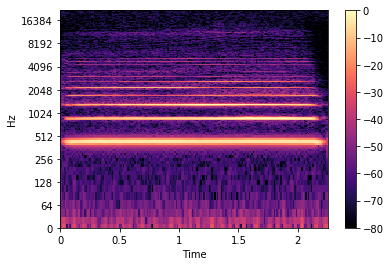

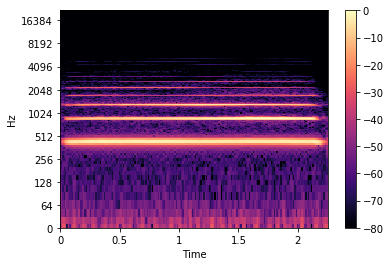

In [4]:

D = librosa.stft(data)  
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db, sr = 44100, x_axis='time', y_axis='log')
plt.colorbar()


newdata = low_pass_filter(data, 1000,samplerate, q=1)
D = librosa.stft(newdata)  
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db, sr = 44100, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()


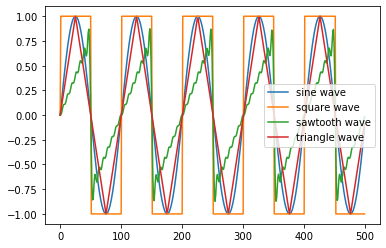

In [5]:
@njit
def sine_wave(frequency, length, phase=0, volume=1., samplerate=44100):
    return volume * np.sin(2 * np.pi * frequency * np.arange(length) / samplerate + phase)
@njit
def square_wave(frequency, length, phase=0, volume=1., samplerate=44100):
    return volume * np.sign(sine_wave(frequency, length, phase, samplerate))
@njit
def sawtooth_wave(frequency, length, phase=0, volume=1., samplerate=44100):
    iters = 15
    t = np.arange(length)/samplerate + phase
    out = []
    for tt in t:
        s = np.array([(-1)**k * np.sin(2 * np.pi * k * frequency * tt) / k for k in range(1, iters)])
        out.append(-0.5 * np.sum(s))
    out = np.array(out)
    return np.multiply(volume, out)

@njit
def triangle_wave(frequency, length, phase=0, volume=1., samplerate=44100):
    return volume * 2/np.pi * np.arcsin(np.sin(2 * np.pi * frequency * np.arange(length) / samplerate + phase))
@njit
def white_noise(length, volume=1., samplerate=44100):
    return volume * np.random.uniform(-1.0, 1.0, size=length)
@njit
def red_noise(length, volume=1., samplerate=44100):
    base = np.random.uniform(-1.0, 1.0, size=length)
    for i in range(1, len(base), 2):
        base[i] = (base[i-1] + base[i+1])/2
    return volume * base

freq = 440
l = 500
t = np.arange(0, l)
plt.plot(t, sine_wave(freq, l), label='sine wave')
plt.plot(t, square_wave(freq, l), label='square wave')
plt.plot(t, sawtooth_wave(freq, l), label='sawtooth wave')
plt.plot(t, triangle_wave(freq, l), label='triangle wave')
plt.legend()
plt.show()

In [6]:
def mix(signal, *signals):
    output = signal.copy()
    for s in signals:
        output += s
    output = np.clip(output, -1, 1)
    return output

In [7]:
sine = sine_wave(440, 200000, volume = 0.1)
square = square_wave(440, 200000, volume = 0.5)
m = mix(sine, square)

Audio(red_noise(200000, volume = 0.001), rate=samplerate)


In [8]:
Audio(white_noise(200000, volume = 0.001), rate=samplerate)

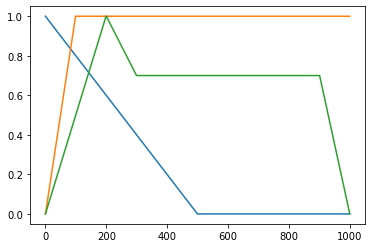

In [9]:
def adsr(samples, a=0.1, d=0.2, s=0.6, r=0.1):
    assert a + d + r <= 1
    t = np.zeros_like(samples)
    a_samples = int(len(t) * a)
    d_samples = int(len(t) * d)
    r_samples = int(len(t) * r)
    
    s_samples = len(t) - a_samples - d_samples - r_samples
       
    a_f = np.linspace(0, 1, a_samples)
    d_f = np.linspace(1, s, d_samples)
    s_f = np.array([s] * s_samples)
    r_f = np.linspace(s, 0, r_samples)
    out = np.concatenate((a_f, d_f, s_f, r_f))
    return out

samples = np.arange(0, 1000)

plt.plot(adsr(samples, a=0, d=0.5, s=0, r=0))
plt.plot(adsr(samples, a=0.1, d=0.1, s=1, r=0))
plt.plot(adsr(samples, a=0.2, d=0.1, s=0.7, r=0.1))

In [10]:
from collections import defaultdict
from numba import njit

@njit
def _sine(i, p, v):
    value = np.sin(i + p)
    value *= v
    return max(-1.0, min(value, 1.0))

@njit
def _square(i, p, v):
    value = np.sign(np.sin(i + p))
    value *= v
    return max(-1.0, min(value, 1.0))

@njit
def _triangle(i, p, v):
    value = 2/np.pi * np.arcsin(np.sin(i + p))
    value *= v
    return max(-1.0, min(value, 1.0))

@njit
def _sawtooth(i, p, v):
    iters = 15
    s = np.array([(-1)**k * np.sin(i * k + p) / k for k in range(1, iters)])
    value = -0.5 * v * np.sum(s)
    return max(-1.0, min(value, 1.0))

@njit
def _white_noise(i, p, v):
    value = np.random.uniform(-1.0, 1.0)
    value *= v
    return max(-1.0, min(value, 1.0))

class Generator():    
    @staticmethod
    def LFO(freq, phase = 0):
        return Generator(freq, 1, phase)
    
    def __init__(self, freq=0, volume=1., phase=0, default_shape = 'sine'):
        self.initial_freq = freq
        self.initial_volume = volume
        self.initial_phase = phase
        
        self.f = freq
        self.v = volume
        self.p = phase
        
        self.sr = 44100
        self.i = 0
        self.modulators = []
        
        self.props = defaultdict(float)
        self.default_shape = default_shape
        
    def set_frequency(self, new_f):
        self.initial_freq = new_f
        self.f = new_f
        
    def set_volume(self, new_v):
        self.initial_volume = new_v
        self.v = new_v
        
    def set_phase(self, new_p):
        self.initial_phase = new_p
        self.p = new_p
        
    def sample(self, func = None):
        if func == None:
            func = self.default_shape
        f = getattr(self, func)
        self._apply_modulators()
        val = f()
        self.i += 2 * np.pi * self.f / self.sr
        return val
        
    def sine(self):
        return _sine(self.i, self.p, self.v)
    
    def square(self):
        return _square(self.i, self.p, self.v)

    def triangle(self):
        return _triangle(self.i, self.p, self.v)

    def sawtooth(self):
        return _sawtooth(self.i, self.p, self.v)
    
    def white_noise(self):
        return _white_noise(self.i, self.p, self.v)
    
    def red_noise(self):
        if self.props['step'] == 0:
            self.props['prev_rand'] = np.random.uniform(-1.0, 1.0)
            self.props['next_rand'] = np.random.uniform(-1.0, 1.0)
            value = self.props['prev_rand']
            self.props['step'] = 1
            return np.clip(self.v * value, -1, 1)
        
        elif self.props['step'] == 1:
            value = (self.props['prev_rand'] + self.props['next_rand'])/2
            self.props['step'] = 2
            return np.clip(self.v * value, -1, 1)
            
        elif self.props['step'] == 2:
            value = self.props['next_rand']
            self.props['step'] = 0
            return np.clip(self.v * value, -1, 1)
        
    def add_modulator(self, lfo, shape, to_modulate, amount):
        supported_params = ["pitch", "volume", "phase"]
        supported_shapes = ["sine", "square", "triangle", "sawtooth", "white_noise", "red_noise"]
        if to_modulate not in supported_params:
            raise ValueError(f"Modulation {to_modulate} not supported. Supported: {supported_params}")
        if shape not in supported_shapes:
            raise ValueError(f"Modulation shape {shape} not supported. Supported: {supported_shapes}")
        self.modulators.append({"lfo": lfo, "shape":shape, "func": to_modulate, "amount": amount})
        
    def _apply_modulators(self):
        for modulator in self.modulators:
            modulator['lfo']._apply_modulators()
            val = modulator['lfo'].sample(modulator['shape'])
            if modulator["func"] == "pitch":
                self.f = self.initial_freq + self.initial_freq * val * modulator['amount']
            elif modulator["func"] == "volume":
                self.v = self.initial_volume + self.initial_volume * val * modulator['amount']
            elif modulator["func"] == "phase":
                self.p = self.initial_phase + self.initial_phase * val * modulator['amount']

In [11]:
def mix(*waves):
    output = np.zeros_like(waves[0])
    for wave in waves:
        output += wave
    output = np.clip(output, -1.0, 1.0)
    return output
   

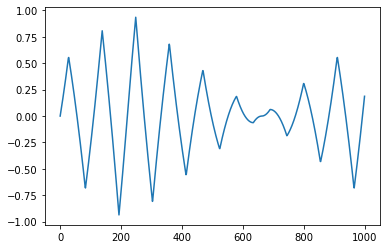

In [12]:
gen1 = Generator(400, 0.5, default_shape = 'triangle')
gen1.add_modulator(Generator.LFO(50), "triangle", "volume", 1)

v1 = [gen1.sample() for i in range(1000)]

plt.plot(v1)

In [13]:
import pandas as pd

n_csv = pd.read_csv('https://gist.githubusercontent.com/matozoid/18cddcbc9cfade3c455bc6230e1f6da6/raw/fb9c5ff8447c6b7f2ed5ca34635b87a4782b9f89/sid_frequencies.csv')
notes = {}
for index, row in n_csv.iterrows():
    note = row['name'] + str(row['octave'])
    notes[note] = row['frequency (base 440Hz)']

def notes_to_freqs(note_list):
    freqs = []
    for note in note_list:
        if note not in notes:
            freqs.append(0)
        else:
            freqs.append(notes[note])
    return freqs

def shift_note(note, semitones):
    note_arr = list(notes)
    if note not in note_arr:
        return note
    shifted_index = note_arr.index(note) + semitones
    if shifted_index < 0:
        shifted_note = note_arr[0]
    elif shifted_index >= len(note_arr):
        shifted_note = note_arr[-1]
    else:
        shifted_note = note_arr[shifted_index]
    return shifted_note
 
def shift(note_list, semitones):
    note_arr = list(notes)
    shifted_notes = []
    for note in note_list:
        shifted_notes.append(shift_note(note, semitones))
    return shifted_notes

def chord(note, convert_to_freq = True, *notes): #note = AM = A Major Am = A minor
    if convert_to_freq:
        fn = lambda c: notes_to_freqs(c)
    else:
        fn = lambda c: c
    chord_type = note.split()[1]
    base = note.split()[0]
    if chord_type == "M": # Major = 0, 4, 7
        return fn([base, shift_note(base, 4), shift_note(base, 7), *notes])
    if chord_type == "m": # Minor = 0, 3, 7
        return fn([base, shift_note(base, 3), shift_note(base, 7), *notes])
    if chord_type == "dim": # Diminished = 0, 3, 6
        return fn([base, shift_note(base, 3), shift_note(base, 6), *notes])
    if chord_type == "M7": # Major 7th - 0, 4, 7, 11
        return fn([base, shift_note(base, 4), shift_note(base, 7), shift_note(base, 11), *notes])
    if chord_type == "m7": # Minor 7th - 0, 3, 7, 10
        return fn([base, shift_note(base, 3), shift_note(base, 7), shift_note(base, 10), *notes])
    if chord_type == "M9": # Major 9th
        return fn([base, shift_note(base, 4), shift_note(base, 7), shift_note(base, 10), shift_note(base, 14), *notes])
    if chord_type == "m9":
        return fn([base, shift_note(base, 3), shift_note(base, 7), shift_note(base, 10), shift_note(base, 14), *notes])
    if chord_type == "M(add9)":
        return fn([base, shift_note(base, 4), shift_note(base, 7), shift_note(base, 14), *notes])
    
print(chord('D#5 m9', False))

['D#5', 'F#5', 'A#5', 'C#6', 'F6']


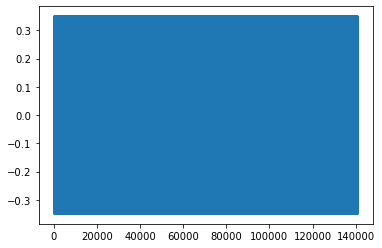

In [14]:
class Instrument:
    def __init__(self, generators):
        self.generators = generators
        
    def _note(self, note):
        for g in self.generators:
            g.set_frequency(note)
        
    def play(self, notes, durations, a = 0, d = 0, s = 1, r = 0, convert=True): #durations in ms
        assert len(notes) == len(durations), f"Notes {len(notes)} have different length than durations {len(durations)}"
        output = []
        for note, duration in zip(notes, durations):
            n_samples = int( (44100* duration) / 1000)
            envelope = adsr(np.arange(0, n_samples), a, d, s, r)
            if not isinstance(note, list):
                if convert:
                    note = notes_to_freqs([note])[0]
                out = np.zeros(shape = (len(self.generators), n_samples))
                self._note(note)
                for i, g in enumerate(self.generators):
                    samples = [g.sample() for _ in range(n_samples)] 
                    out[i] = samples #/np.max(samples)
                mixd = mix(*out)
                output.extend(mixd * envelope)
            else:
                if convert:
                    note = notes_to_freqs(note)
                out = np.zeros(shape = (len(note), len(self.generators), n_samples))
                mixd = []
                for i, chord_part in enumerate(note):
                    self._note(chord_part)
                    for j, g in enumerate(self.generators):
                        samples = [g.sample() for _ in range(n_samples)] 
                        out[i][j] = samples #/np.max(samples)
                    mixd_gens = mix(*out[i])
                    mixd.append(mixd_gens)
                mixd = mix(*mixd)
                output.extend(mixd * envelope)
        return np.array(output)

i = Instrument([Generator(volume = 0.3, default_shape = 'sine'), Generator(volume = 0.05, default_shape = 'square')])



c = i.play([391.9, 329.6, 329.6, 349.6, 293.7, 293.7, 261.6, 329.6, 391.9], 
           [400,   400,   400,   400,   400,   400,   200,   200,   400], convert=False)

cutoff_lfo = Generator.LFO(2)
cutoffs = [500 + 500 * cutoff_lfo.sample("triangle") for _ in range(len(c))]
#print(cutoffs)
#c = low_pass_filter(c, cutoffs)
plt.plot(c)
sf.write("wlazlkotek.wav",c, 44100)
Audio(c, rate=samplerate)

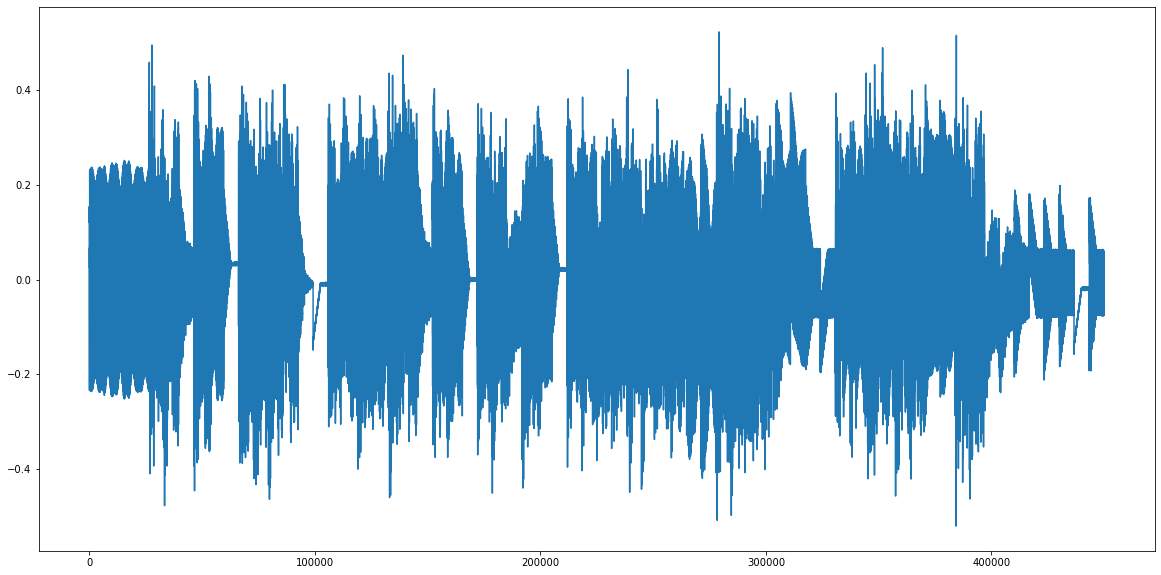

In [15]:
import time


#freqs     = [391.9, 329.6, 329.6, 349.6, 293.7, 293.7, 261.6, 329.6, 391.9]
#durations = [400,   400,   400,   400,   400,   400,   200,   200,   400]


chords = Instrument([Generator(volume = 0.3, default_shape = 'sine'), 
                     Generator(volume = 0.05, default_shape = 'square')])

chord_progr = chords.play([
    0,
    ['F#3', 'A#3', 'C#4', 'F4'],
    ['G#3', 'C4', 'D#4', 'G#4'],
    ['F3', 'G#4', 'C4', 'F4'],
    ['A#3', 'C#4', 'F4', 'A#4'],
    ['F#3', 'A#3', 'C#4', 'F4'],
    ['G#3', 'C4', 'D#4', 'G#4'],
    ['F3', 'G#4', 'C4', 'F4'],
    ['A#3', 'C#4', 'F4', 'A#4'],
], [4*150, 900, 1500, 900, 1500, 900, 1500, 900, 1500], a=0.01, d=0.5, s=0, r=0)

chord_progr = low_pass_filter(chord_progr, 1400, 44100, q=3)

gen1 = Generator(volume = 0.7, default_shape = 'sine')
gen2 = Generator(volume = 0.01,default_shape = 'red_noise')
gen3 = Generator(volume = 0.3, phase = np.pi/4, default_shape = 'square')
gen1.add_modulator(Generator.LFO(4), "sine", "phase", 1)
gen3.add_modulator(Generator.LFO(8), "sine", "pitch", 0.03)
lead = Instrument([gen1, gen2, gen3])

lead_progr = lead.play(shift([
    'A3', 'B3', 'C4', 'A3', 'E4', 'E4', 0   , 'E4',
    'E4', 0   , 'D4', 'D4', 'D4', 'D4', 0   , 0   ,
    'G3', 'A3', 'B3', 'G3', 'D4', 'D4', 0   , 'D4',
    'D4', 0   , 'C4', 'C4', 0   , 'B3', 'A3', 0   ,
    'A3', 'B3', 'C4', 'A3', 'C4', 'C4', 'C4', 'C4',
    'D4', 'D4', 'B3', 'B3', 'B3', 'A3', 'G3', 'G3',
    0   , 0   , 'G3', 'G3', 'D4', 'D4', 'D4', 'D4',
    'C4', 'C4', 'C4', 'C4', 0   , 0   , 0   , 0,
    0, 0, 0, 0
], 1), [150] * (8 * 8 + 4))

lead_progr = high_pass_filter(lead_progr, 600, 44100, q=1)

background = Instrument([Generator(volume = 0.45, default_shape = 'sawtooth')])
background_progr = background.play([
    0, 0, 0, 0, 'C#6', 'C#6', 'C#6', 'C#6',
    0, 0, 'D#6', 'D#6', 'D#6', 'D#6', 0, 0,
    'G#5', 'G#5', 'G#5', 'G#5', 'D#6', 'D#6', 'D#6', 'D#6',
    0, 0, 'F6', 'F6', 'F6', 'F6', 0, 0,
    'G#7', 'F#6', 'F6', 'C#6', 'C#6', 'C#6', 'C#6', 'C#6',
    0, 0, 'D#6', 'D#6', 'D#6', 'D#6', 0, 0,
    'G#5', 'G#5', 'G#5', 'G#5', 'D#6', 'D#6', 'D#6', 'D#6',
    0, 0, 'F6', 'F6', 'F6', 'F6', 'G#5', 'G#5',
    'A#5', 'C#6', 0, 'C#6'
], [150] * (8 * 8 + 4))

bass = Instrument([Generator(volume = 0.6, default_shape = 'square')])
bass_progr = bass.play(shift([
    0, 0, 0, 0, 'D#3', 0, 'D#3', 'D#3',
    'D#3', 'C4', 'A#3', 0, 'G#3', 0, 'G#3', 0,
    'G#3', 0, 'F3', 'G#3', 'F3', 0, 'F3', 'F3',
    'F3', 'C4', 'A#3', 0, 0, 0, 'A#3', 'A#3',
    'A#3', 'C4', 0, 'A#3', 'D#3', 0, 'D#3', 'D#3',
    'D#3', 'C4', 'A#3', 0, 'G#3', 0, 'G#3', 0,
    'G#3', 0, 'F3', 'G#3', 'F3', 0, 'F3', 'F3',
    'F3', 'C4', 'A#3', 0, 0, 0, 'G#3', 0,
    'G#3', 'G#3', 0, 'G#3'
], -12), [150] * (8 * 8 + 4), a=0, d=0.5, s=0, r=0)


full = mix(0.15 * chord_progr, 0.4 * lead_progr, 0.2 * bass_progr, 0.2 * background_progr)

full = low_pass_filter(full, 3000, 44100, 1)
    
plt.figure(figsize=(20,10))
plt.plot(full)
sf.write("rain_2.wav",full, 44100)
sf.write("chords_2.wav",chord_progr, 44100)
Audio(full, rate=samplerate)


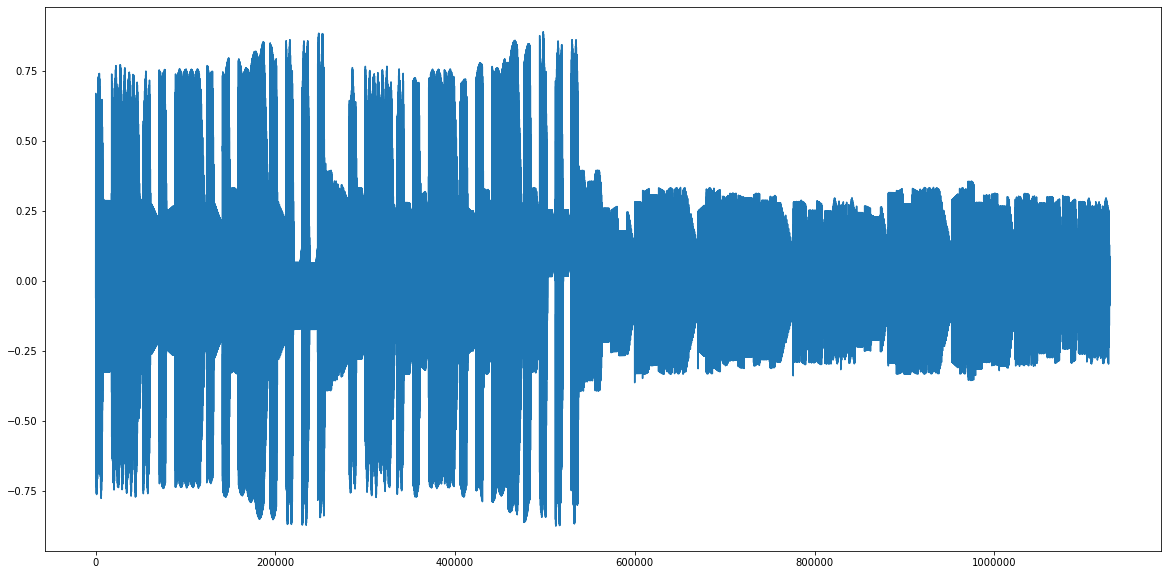

In [17]:
chords = Instrument([Generator(volume = 0.3, default_shape = 'sine'), 
                     Generator(volume = 0.05, default_shape = 'square')])

_16 = 100
_8 = 2 * _16
_4 = 2 * _8
_2 = 2 * _4
_1 = 2 * _2

chord_progr = chords.play([
    ['B5', 'D6'], 'G5',['B5', 'D6'],['B5', 'D6'],'G5',
    
    ['B5', 'D6'], 'F#5', ['B5', 'D6'], ['B5', 'D6'], 'F#5',
    
    ['B5', 'E6'], 'G5', ['B5', 'E6'], ['B5', 'E6'], 'G5',
    
    ['E6', 'C6'], 0, ['E6', 'C6'], 0, ['E6', 'C6'], 'B5', 'A5', 'B5',
    ['B5', 'D6'], 'G5',['B5', 'D6'],['B5', 'D6'],'G5',
    
    ['B5', 'D6'], 'F#5', ['B5', 'D6'], ['B5', 'D6'], 'F#5',
    
    ['B5', 'E6'], 'G5', ['B5', 'E6'], ['B5', 'E6'], 'G5',
    
    ['E6', 'C6'], 0, ['E6', 'C6'], 0, ['E6', 'C6'], 'B5', 'A5', 'B5',
    
    'G4', 'G5', 'F#5', 'G5', 'F#5', 'D5', 'E5',
    'C5', 'C5', 'C5', 'B4', 'A4', 'B4',
    
    'G4', 'G5', 'F#5', 'G5', 'A5', 'F#5', 'E5',
    'D5', 'E5', 'D5', 'B4', 'C5', 'C5', 'C5', 'B4', 'A4', 'B4',
    
], [
    _8, _8, _2, _8, _8,
    _8, _8, _2, _8, _8,
    _8, _8, _2, _8, _8,
    _8, _8, _8, _8, _8, _8, _8, _8
] * 2  
    + [_2, _1, _8, _8, _8, _8, _1, _4, _4, _8, _8, _8, _8] 
    + [_2, _1, _8, _8, _8, _8, _2, _8, _8,_8,_8, _4, _4, _8, _8, _8, _8], 
    a=0, d=0, s=1, r=0.2)
chord_progr = low_pass_filter(chord_progr, 1400, 44100, q=3)

bass = Instrument([Generator(volume = 0.6, default_shape = 'triangle')])
bass_progr = bass.play([
    'G3', 'B3', 'E3', 'C4',
    'G3', 'G3', 'G3', 'G3', 
    'B3', 'B3','B3','B3', 
    'E3', 'E3','E3','E3', 
    'C4', 'C4', 'C4', 'C4',
    'G2', 'D3', 'G3', 'D3', 'G3', 'D3', 'G3', 'D3',
    'B2', 'F#3', 'B3', 'F#3', 'B3', 'F#3', 'B3', 'F#3',
    'E2', 'B2', 'E3', 'B2', 'E3', 'B2', 'E3', 'B2',
    'C2', 'G3', 'C3', 'G3', 'C3', 'G3', 'C3', 'G3',
    
    'G2', 'D3', 'G3', 'D3', 'G3', 'D3', 'G3', 'D3',
    'B2', 'F#3', 'B3', 'F#3', 'B3', 'F#3', 'B3', 'F#3',
    'E2', 'B2', 'E3', 'B2', 'E3', 'B2', 'E3', 'B2',
    'C2', 'G3', 'C3', 'G3', 'C3', 'G3', 'C3', 'G3'
], [_1] * (4) + [_4, _4, _4, _4] * 4 + [_8] * 32 + [_8] * 32, a=0, d=0, s=1, r=0.2)


full = mix(0.2 * bass_progr, 0.4 * chord_progr)

full = low_pass_filter(full, 3000, 44100, 1)
    
plt.figure(figsize=(20,10))
plt.plot(full)
sf.write("office.wav",full, 44100)
Audio(full, rate=samplerate)

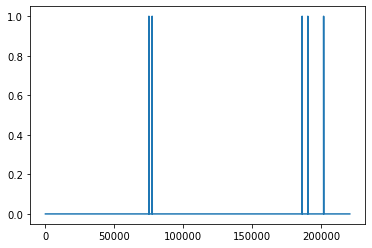

In [18]:
def delay(source, offset_samples, factor=1, repeats=1):
    for i in range(repeats):
        offs = offset_samples * (i + 1)
        delayed = source.copy()
        delayed[0:offs] = 0
        delayed[offs:] = source[0:len(source)-offs]
        delayed *= factor**(i + 1)
        source = mix(source, delayed)
    return source

def to_samples(ms, samplerate = 44100):
    return int((ms/1000) * samplerate)

def comb(signal,delay,gain):
    newsignal = signal.copy()
    for i in range(0,len(signal)-delay):
        newsignal[i+delay] +=  gain * signal[i]
    return np.array(newsignal)

def all_pass_filter(signal,delay,gain):
    #y[n] = (−g·x[n]) + x[n−M] + (g·y[n−M])
    newsignal = signal.copy()
    for i in range(0,len(signal)-delay):
        newsignal[i+delay] +=  -gain * signal[i+delay] + signal[i] + gain * newsignal[i]
    return np.array(newsignal)

def reverb(samples,reverbs = 2,gain = 0.75, wet_percent = 0.1):
    og = samples.copy()
    combs = []
    for r in range(reverbs):
        combs.append(comb(samples,len(samples)//8,gain * (1-(r/100))))
    combs = np.array(combs)
    samples = np.sum(combs,axis=0)
    samples = all_pass_filter(samples,len(samples)//16,gain/2)
    samples = all_pass_filter(samples,len(samples)//32,gain/4)
    samples = samples * wet_percent + og * (1 - wet_percent)
    return samples

def impulses(length, impulse_width, n_of_drops):
    out = np.zeros(shape=length)
    indices = np.arange(0, length)
    drop_positions = sorted(np.random.choice(indices, size=n_of_drops))
    for pos in drop_positions:
        if(pos + impulse_width >= length):
            out[pos:] = 1
        else:
            out[pos:pos + impulse_width] = 1
    return np.clip(out, -1, 1)

drops = impulses(5 * 44100, 3, 5)
plt.plot(drops)
Audio(drops, rate=samplerate)

In [19]:

i = Instrument([Generator(volume = 0.3, default_shape = 'sine'), Generator(volume = 0.05, default_shape = 'square')])



c = i.play([391.9, 329.6, 329.6, 349.6, 293.7, 293.7, 261.6, 329.6, 391.9], 
           [400,   400,   400,   400,   400,   400,   200,   200,   400])

cutoff_lfo = Generator.LFO(2)
cutoffs = [500 + 500 * cutoff_lfo.sample("triangle") for _ in range(len(c))]
#print(cutoffs)
c = low_pass_filter(c, cutoffs)
c = delay(c, to_samples(250))
sf.write("wlazlkotek.wav",c, 44100)
Audio(c, rate=samplerate)

c:\users\mikolaj\appdata\local\programs\python\python38\lib\site-packages\IPython\lib\display.py:172: RuntimeWarning: invalid value encountered in true_divide
  scaled = data / normalization_factor * 32767


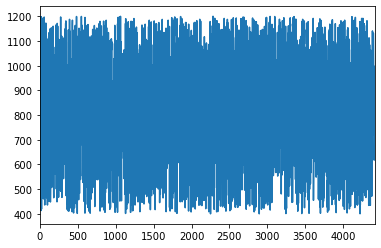

In [22]:
lfo = Generator.LFO(30/10)

bg_noise = Generator(0, 0.5)

lfo_samples = [800 + 400 * lfo.sample('red_noise') for i in range(15 * 44100)]
bg_samples = [bg_noise.sample('red_noise') for i in range(15 * 44100)]
bg_samples = low_pass_filter(bg_samples, 1200, 44110, 5)
data = impulses(15 * 44100, 3, 50)

out = low_pass_filter(data, lfo_samples, q = 15)
out /= np.max(np.abs(out), axis=0)
out = np.clip(out, -1, 1)

plt.plot(lfo_samples)
plt.xlim(0, 4410)
out = mix(0.8 * out, 0.0 * bg_samples)
#out = delay(out, to_samples(180), factor = 0.5, repeats = 3)

#out = low_pass_filter(out, 2000, 44110, 2)
#out = high_pass_filter(out, 200, 44110, 2)
out = reverb(out, wet_percent = 0.2)
sf.write("rain.wav", out, 44100)
Audio(out, rate=samplerate)

#plt.plot(low_pass_filter(carrier_samples, 500, 44100, 3))

### Report

First we started with implementing the filters. To verify their effects we plotted spectograms to see whether signal from some frequency range was muted. The filters support variable cutoff rate.

Later we implemented generator that allows to generate desired signals preserving proper signal phase as we do it sample by sample. It's also possible to modulate the signal in its pitch, volume, phase

This generator could be later used to generate desired melody. To make things more digestable we imported a dataset of notes with their frequencies so we could just make a list of notes and durations so that a melody could be played.

Multiple generators with LFOs can be combined into one instrument for easier playback.

To synthesize the rain sound we had to implement a reverb effect with the use of comb filter and all-pass filter. We introduce red noise and carrier droplet sound signal generated by placig random impulses. To decide on low-pass filter value we analyse lfo red noise signal and take the current value of the lfo as a cutoff frequency. We calculate low-pass for carrier samples in this method ald clip signal to (-1 , 1). This sound is mixed with rain-like red noise for background effect. Lastly we apply reverb to make the sound more echo-y.